# Features

In [1]:
# Standard library imports
import sys

# Third-party library imports
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
from pyproj import CRS, Geod
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
import pandas as pd
import rasterio
from rasterio import features
import numpy as np
from tqdm.notebook import tqdm

# Custom module imports
import project_functions as pf
import importlib
importlib.reload(pf)

<module 'project_functions' from 'c:\\Users\\lissn\\Thesis\\code\\project_functions.py'>

### Radar Coordinates

In [101]:
# Radar coordinates
scale_factor = 1
x_radar_start = -421364.8 - 500/scale_factor
x_radar_end = 569635.2 + 500/scale_factor
y_radar_start = 468631 + 500/scale_factor
y_radar_end = -394369 - 500/scale_factor
x_radar_spacing = 500/scale_factor
y_radar_spacing = -500/scale_factor

# Generate radar coordinates to match the projected grid 
x_radar_coords = np.arange(x_radar_start, x_radar_end + x_radar_spacing, x_radar_spacing)
y_radar_coords = np.arange(y_radar_start, y_radar_end + y_radar_spacing, y_radar_spacing)

# CRS definitions
dmi_stere_crs = CRS("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56") # raw data CRS projection
plotting_crs = 'epsg:4326' # the CRS projection you want to plot the data in

# Project the coordinates to the target CRS efficiently
radar_lons, radar_lats =pf.transform_raster_grid_coordinates(x_radar_coords, y_radar_coords, dmi_stere_crs, plotting_crs)


### Distance to sea

Europe shape file: https://data.dtu.dk/articles/dataset/Shapefile_of_European_countries/23686383

In [ ]:
# Read shapefile
europe = gpd.read_file('C:/Users/lissn/Thesis/data/meta_data/Europe/Europe_merged.shp')

# Clip the shape file such that it only contains the area around the radar
bbox_corners = [
    (x_radar_start, y_radar_start),
    (x_radar_start, y_radar_end),
    (x_radar_end, y_radar_end),
    (x_radar_end, y_radar_start),
    (x_radar_start, y_radar_start)  # Close the polygon
]
bbox_polygon = Polygon(bbox_corners)
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs=dmi_stere_crs)  # Use the radar's CRS
bbox_gdf = bbox_gdf.to_crs(europe.crs)
dk = gpd.clip(europe, bbox_gdf)

# Use the same CRS as the radar data
if dk.crs != plotting_crs:
    dk = dk.to_crs(plotting_crs)


Coast data: https://www.eea.europa.eu/data-and-maps/data/eea-coastline-for-analysis-1/gis-data/europe-coastline-shapefile 

In [ ]:
# Read European coastline shapefile
coastline = gpd.read_file('C:/Users/lissn/Thesis/data/meta_data/Europe_coastline_shapefile/Europe_coastline.shp')

# Clip the shape file such that it only contains the area around the radar
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs=dmi_stere_crs)  # Use the radar's CRS
bbox_gdf = bbox_gdf.to_crs(coastline.crs)
coastline_clipped = gpd.clip(coastline, bbox_gdf)

# Use the same CRS as the radar data
if coastline_clipped.crs != plotting_crs:
    coastline_clipped = coastline_clipped.to_crs(plotting_crs)

In [ ]:
# radar_lons and radar_lats represents the projected coordinates of each radar pixel
radar_points = [Point(lon, lat) for lon, lat in zip(np.ravel(radar_lons), np.ravel(radar_lats))]
radar_gdf = gpd.GeoDataFrame(pd.DataFrame(radar_points, columns=['geometry']), geometry='geometry', crs=plotting_crs)

def compute_nearest_coastline_distances(radar_gdf, coastline):
    # Ensure coastline has a spatial index, which speeds up the querying
    coastline_sindex = coastline.sindex
    nearest_distances = []
    for point in tqdm(radar_gdf.geometry, desc='Computing distances'):
        # Fetch the nearest geometry's index
        nearest_geom_index = list(coastline_sindex.nearest([point], return_all=True))[0]
        nearest_geom = coastline.iloc[nearest_geom_index].geometry
        
        # Compute distance to the nearest coastline geometry
        distance = point.distance(nearest_geom)
        nearest_distances.append(distance)
    return nearest_distances

# Compute the distances to the nearest coastline
radar_gdf['distance_to_coast'] = compute_nearest_coastline_distances(radar_gdf, coastline_clipped)

In [ ]:
# Initialize an empty 2D array with NaNs for the distances
distance_grid = np.full((len(y_radar_coords), len(x_radar_coords)), np.nan)

# Fill the grid with the computed distances
for i, distance in tqdm(enumerate(radar_gdf['distance_to_coast']), total=len(radar_gdf['distance_to_coast'])):
    # Compute row and column indices based on the linear index
    row_idx = i // len(x_radar_coords)
    col_idx = i % len(x_radar_coords)
    distance_grid[row_idx, col_idx] = distance

In [ ]:
# Set distance to 0 at sea:
gdf_points = gpd.GeoDataFrame(geometry=radar_points, crs=plotting_crs)

# Perform a spatial join to find which points are within the dk polygons
# This adds the index of the dk polygon to each point that is inside a land area, NaN otherwise
joined = gpd.sjoin(gdf_points, dk, how="left", predicate="within")

# Initialize an array to hold the mask of points over land (True for land, False for sea)
is_land = ~np.isnan(joined.index_right.values)

# Reshape is_land to match the distance_grid shape
is_land_grid = is_land.reshape(len(y_radar_coords), len(x_radar_coords))

# Zero out values in the distance_grid that are not over land
distance_grid[~is_land_grid] = 0

In [ ]:
# Save the fature as a np array
np.save('dist_coast_01.npy', distance_grid)

c:\Users\lissn\Thesis\code\project_functions.py:810: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


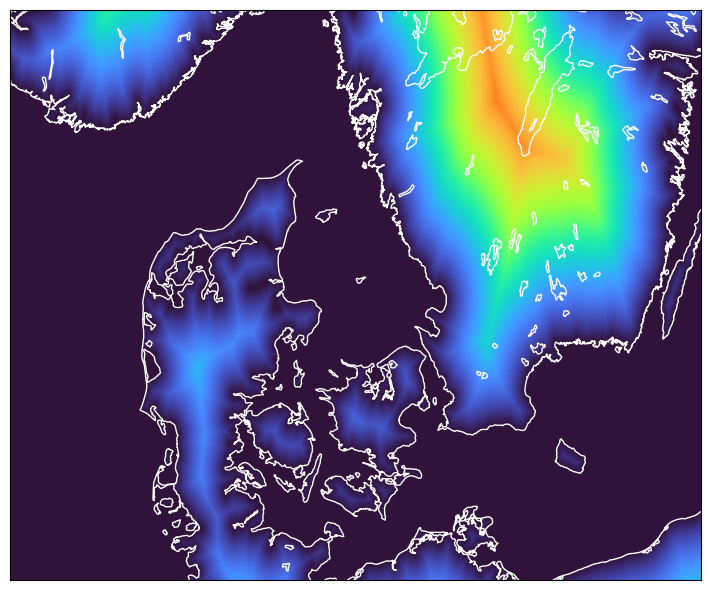

In [74]:
distance_grid = np.load('dist_coast_01.npy',)

# Plot the feature
importlib.reload(pf)
save_path = 'C:/Users/lissn/Thesis/figures/dist_sea.png'
title = 'Distance to coast (degrees)'
pf.plot_adjusted_feature(radar_lons, radar_lats, distance_grid, title, cmap = 'turbo', save_path = save_path)

### Time of year variable

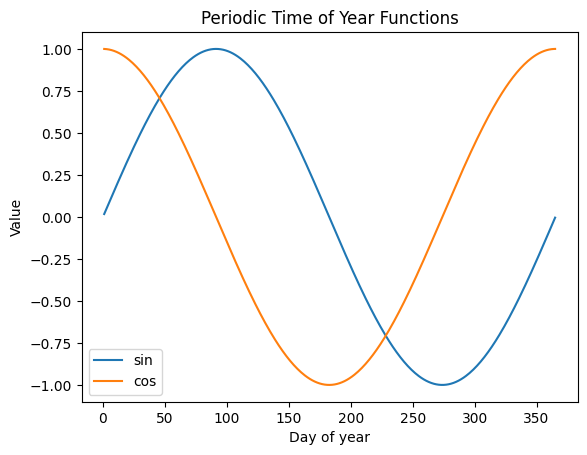

In [2]:
start_date = '2022-01-01'
end_date = '2022-12-31'

# Sample DataFrame with a date column
df = pd.DataFrame({
    'date': pd.date_range(start=start_date, end=end_date, freq='10min')
})

# Calculate the day of the year
df['day_of_year'] = df['date'].dt.dayofyear

# Constants for the transformations
days_in_year = 365.25  # Average to account for leap years

# Apply sine and cosine transformations
df['sin_time_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / days_in_year)
df['cos_time_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / days_in_year)

plt.plot(df['day_of_year'], df['sin_time_of_year'], label='sin')
plt.plot(df['day_of_year'], df['cos_time_of_year'], label='cos')  
plt.xlabel('Day of year')
plt.ylabel('Value')
plt.legend()
plt.title('Periodic Time of Year Functions')
plt.show()

## Distances to radars

In [ ]:
# Load radar meta data
radar_path = 'C:/Users/lissn/Thesis/data/meta_data/radar_meta_data.csv' 
radar_df = pd.read_csv(radar_path)

# Create a GeoDataFrame for radar locations
radar_gdf = gpd.GeoDataFrame(radar_df, geometry=gpd.points_from_xy(radar_df.Longitude, radar_df.Latitude))
radar_gdf.crs = 'epsg:4326'

# Create a GeoDataFrame for radar pixels
pixels = [Point(lon, lat) for lon, lat in zip(np.ravel(radar_lons), np.ravel(radar_lats))]
pixels_gdf = gpd.GeoDataFrame(geometry=pixels, crs='epsg:4326')

In [ ]:
geod = Geod(ellps='WGS84')

# Function to calculate distances from each pixel to a given radar station
def calculate_distances(pixels_gdf, station):
    # Extract station coordinates
    station_lon, station_lat = station.geometry.x, station.geometry.y
    
    # Calculate distance from each pixel to this radar station
    distances = [geod.inv(pixel.x, pixel.y, station_lon, station_lat)[2] for pixel in pixels_gdf.geometry]

    return distances

# Apply function to each station
for i, station in tqdm(radar_gdf.iterrows(), total=radar_gdf.shape[0]):
    distances_to_station = calculate_distances(pixels_gdf, station)
    # Add distances as a new column to pixels_gdf
    pixels_gdf[f'distance_to_station_{station["Name"]}'] = distances_to_station

In [ ]:
# Compute the minimum distance to any station
distance_columns = [col for col in pixels_gdf.columns if col.startswith('distance_to_station')]
pixels_gdf['min_distance_to_any_station'] = pixels_gdf[distance_columns].min(axis=1)

num_lats = len(y_radar_coords)
num_lons = len(x_radar_coords)

# Reshape the minimum distance data
min_distance_array = np.array(pixels_gdf['min_distance_to_any_station']).reshape(num_lats, num_lons)

In [40]:
min_distance_array = np.load('dist_radar_01.npy',)

c:\Users\lissn\Thesis\code\project_functions.py:810: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


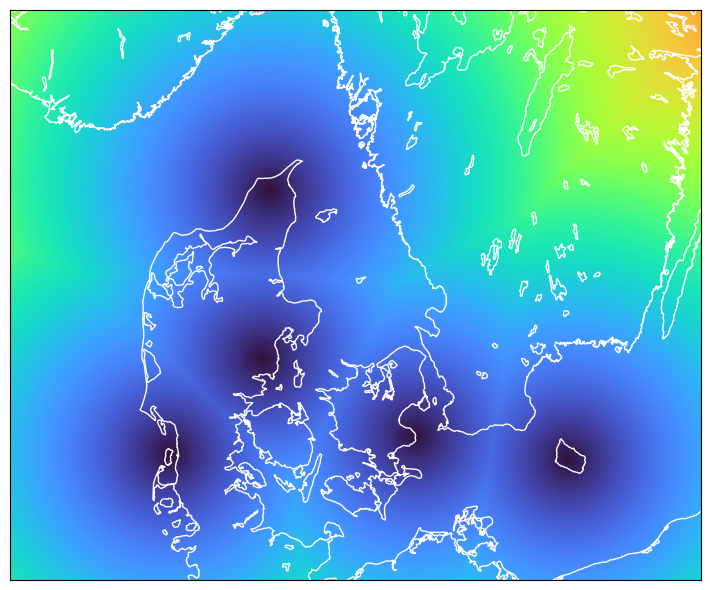

In [73]:
# Save and plot
importlib.reload(pf)
save_path = 'C:/Users/lissn/Thesis/figures/dist_radar.png'
title = 'Distance to nearest radar (m)'
pf.plot_adjusted_feature(radar_lons, radar_lats, min_distance_array, title, 'turbo', save_path)

### Topography

Data is downloaded from: https://data.geus.dk/geusmap/?lang=da&mapname=denmark#baslay=&optlay=&extent=-1105079.7901234569,4988238.285493827,2220079.790123457,7461761.714506173&layers=hoejde_dybde 

In [7]:
# Load the shapefile
shapefile_path = r'C:\Users\lissn\Thesis\data\Topo-bathy\shape_format\data\Land_hojde_5m_2005.shp'
topo_gdf = gpd.read_file(shapefile_path)

# Convert crs
topo_gdf = topo_gdf.to_crs(dmi_stere_crs)

In [10]:
# Define the bounds of the raster based on the radar data extent and the desired resolution
x_res = 500/scale_factor
y_res = 500/scale_factor
x_min, y_min, x_max, y_max = [x_radar_start, y_radar_end, x_radar_end, y_radar_start] 

# Calculate the number of rows and columns
n_cols = int((x_max - x_min) / x_res)
n_rows = int((y_max - y_min) / abs(y_res))

# Create an empty array
raster = np.zeros((n_rows+1, n_cols+1), dtype=np.float32)

# Function to burn the polygons into the raster
def burn_polygons(raster, transform, gdf, value_column):
    rasterized_polygons = features.rasterize(
        ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_column])),
        out_shape=raster.shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.float32)
    raster += rasterized_polygons

# Perform the conversion
burn_polygons(raster, rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, n_cols, n_rows), topo_gdf, 'MAXKOTE')

In [11]:
raster.shape

(1729, 1985)

In [12]:
np.save('topo_01.npy', raster)

c:\Users\lissn\Thesis\code\project_functions.py:953: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colormesh = m.pcolormesh(x, y, input_array, cmap=cmap)


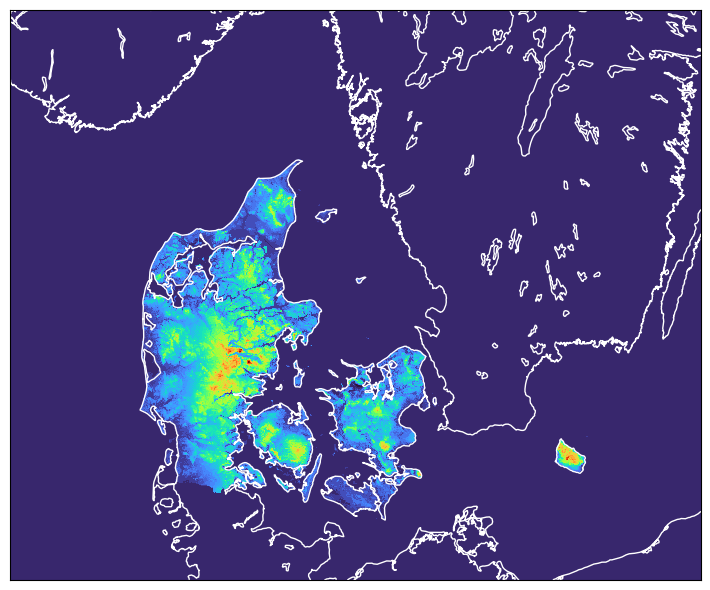

In [13]:
# Plot and save 
importlib.reload(pf)
save_path = 'C:/Users/lissn/Thesis/figures/topo.png'
title = 'Topography (m)'
pf.plot_adjusted_feature(radar_lons, radar_lats, raster, title, 'turbo', save_path)

# Coast/Inland climate

In [10]:
column_names = ['x', 'y', 'cat']
df = pd.read_csv('C:/Users/lissn/Thesis/data/KGDK_1x1km_kyst-indland_23022012.txt', header=None, names=column_names, sep=' ')
df.head(5)

,x,y,cat
1000001,441500,6156500,0.0
1000002,441500,6157500,0.0
1000003,441500,6158500,0.0
1000004,441500,6159500,0.0
1000005,441500,6160500,0.0


In [11]:
from pyproj import Proj, transform

# Coordinate systems
utm32n = Proj('epsg:25832')  # UTM32N coordinates
dmi_stere_crs = Proj("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56")  # Radar coordinate system

# Function to transform coordinates
def transform_coordinates(x, y, from_crs, to_crs):
    return transform(from_crs, to_crs, x, y)

# Applying the transformation
df['x_radar'], df['y_radar'] = zip(*df.apply(lambda row: transform_coordinates(row['x'], row['y'], utm32n, dmi_stere_crs), axis=1))

C:\Users\lissn\AppData\Local\Temp\ipykernel_29116\558393913.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return transform(from_crs, to_crs, x, y)


In [12]:
# Check if the transformed coordinates fall within your radar grid bounds and adjust if necessary
x_radar_coords = np.arange(x_radar_start, x_radar_end + x_radar_spacing, x_radar_spacing)
y_radar_coords = np.arange(y_radar_start, y_radar_end + y_radar_spacing, y_radar_spacing)

# Example of aligning: snapping to the nearest grid point (simple method)
df['x_aligned'] = np.round((df['x_radar'] - x_radar_start) / x_radar_spacing) * x_radar_spacing + x_radar_start
df['y_aligned'] = np.round((df['y_radar'] - y_radar_start) / y_radar_spacing) * y_radar_spacing + y_radar_start

In [139]:
from scipy.interpolate import griddata

is_land_grid = np.load('is_land_grid.npy')
topo = np.load('topo_01.npy')
binary_topo = np.where(topo != 0, 1, 0)


# Define the grid
x_grid = np.linspace(x_radar_start, x_radar_end, len(x_radar_coords))
y_grid = np.linspace(y_radar_start, y_radar_end, len(y_radar_coords))
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate data onto grid
Z = griddata((df['x_aligned'], df['y_aligned']), df['cat'], (X, Y), method='linear')
Z *= is_land_grid 

In [151]:
np.save('climate.npy', Z)

c:\Users\lissn\Thesis\code\project_functions.py:953: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colormesh = m.pcolormesh(x, y, input_array, cmap=cmap)


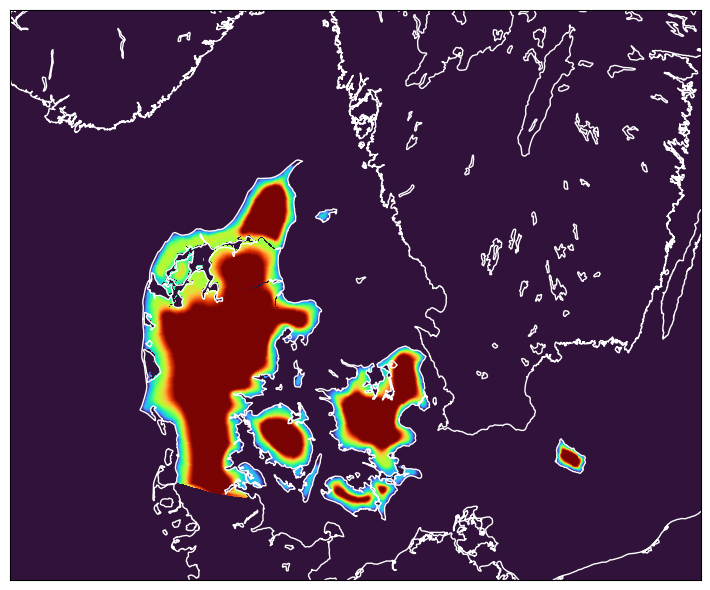

In [140]:
# Plot and save 
Z[np.isnan(Z)] = 0
Z/=100
importlib.reload(pf) 
save_path = 'C:/Users/lissn/Thesis/figures/climate.png'
title = 'Climate (%)'
pf.plot_adjusted_feature(radar_lons, radar_lats, Z, title, 'turbo', save_path)

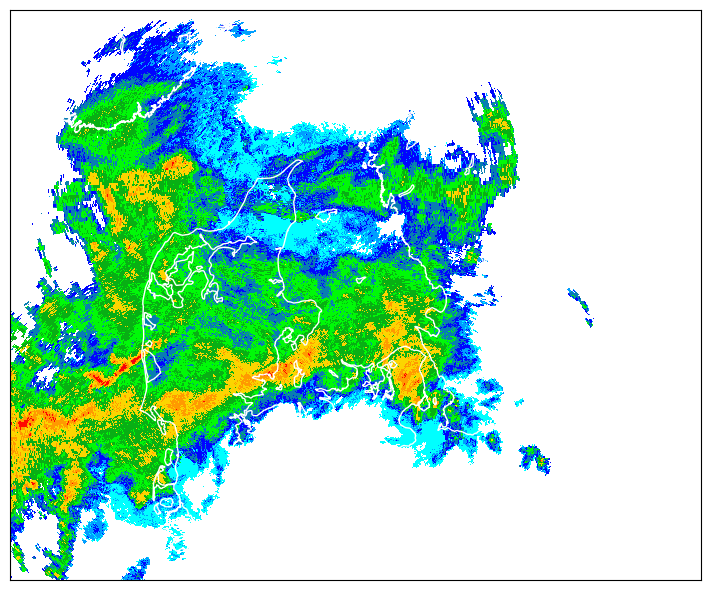

In [150]:
importlib.reload(pf)
from datetime import datetime
data_dir =  f"C:/Users/lissn/Thesis/data/radar"
year = '2023'
month = '10'
day = '03'
hour = '02'
minute = '00'

from matplotlib import colors    
from matplotlib.colors import BoundaryNorm

# Use the function to create the colormap
cmap = pf.read_rgb_file('radar.rgb')
boundaries = np.linspace(0, 75, 16)
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

# Combine the components into a single datetime string
datetime_str = f"{year}-{month}-{day} {hour}:{minute}"
date = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

file_path = f"{data_dir}/{year}/{year}/{month}/{day}/dk.com.{year}{month}{day}{hour}{minute}.500_max.h5"
radar_image, success = pf.load_radar_image(file_path) 

radar_image[radar_image == 255] = np.nan # values of 255 in raw data are actually NaN
zero_values = radar_image == 0 # store where zero values are located in the grid, as these are changed by the transformation below
gain = 0.5
offset = -32
dbz_data = offset + gain * radar_image # convert to dBZ
dbz_data[zero_values] = np.nan

save_path = 'C:/Users/lissn/Thesis/figures/radar_image.png'
title = 'radar (%)'
pf.plot_adjusted_feature(radar_lons, radar_lats, dbz_data, title, cmap, norm, save_path)